# Data from EIA Annual Electric Power Industry Report, Form EIA-861 detailed data files

https://www.eia.gov/electricity/data/eia861/

In [1]:
import numpy as np
import pandas as pd

In [2]:
def get_DR_file(year):
    name = 'DSM' if year < 2013 else 'Demand_Response'
    if year == 2012:
        name = 'dsm'
    app = 'xlsx' if (year not in [2012, 2013, 2014]) else 'xls'
    sheet = 'Demand Response_States' if year > 2012 else 'States'
    if year == 2007:
        sheet = 'DSM- States'
    if year == 2008:
        sheet = 'DSM-State'
    if year == 2009:
        sheet = 'DSM'
    head = 2
    df = pd.read_excel(f'data/all_DR/{name}_{year}.{app}', sheet_name=sheet, header=head)
    return df

def get_util_BA_mapping_file(year):
    app = 'xlsx' if (year not in [2013, 2014]) else 'xls'
    sheet = 'States'
    head = 2
    df = pd.read_excel(f'data/all_DR/Sales_Ult_Cust_{year}.{app}', sheet_name=sheet, header=2)
    df = df.sort_values(by=['Utility Number'])
    df.reindex
    return df

def util_to_BA_mapping(BAs):
    print(BAs)
    yrs = []
    bas = []
    utils = []
    util_nums = []
    states = []
    for yr in range(2013, 2020):
         
        if yr <= 2016:
            ba_code = 'BA_CODE'
        elif yr == 2016:
            ba_code = 'BA CODE'
        else:
            ba_code = 'BA Code'
        df = get_util_BA_mapping_file(yr)
        #print("\n\n\n\n",yr, ba_code)
        #print(df.head())
        for idx in df.index:
            if df.loc[idx, ba_code] in BAs:
                #if df.loc[idx, 'Utility Name'] == 'Adjustment 2019' or df.loc[idx, 'Utility Name'] == 'Withheld':
                #    continue
                if len(utils) > 0 and util_nums[-1] == df.loc[idx, 'Utility Number'] and states[-1] == df.loc[idx, 'State']:
                    print(f"Skipping repeat instance of {df.loc[idx, 'Utility Number']} and {df.loc[idx, 'State']}")
                    continue
                yrs.append(yr)
                bas.append(df.loc[idx, ba_code])
                utils.append(df.loc[idx, 'Utility Name'])
                util_nums.append(df.loc[idx, 'Utility Number'])
                states.append(df.loc[idx, 'State'])
        
    
    master = pd.DataFrame({'year':yrs, 'BA':bas, 'Utility':utils, 'Utility Number': util_nums, 'State':states})
    master.to_csv('mapping.csv')
    print(master)
    return master

In [3]:
BAs = ['ERCO','NYIS', 'PJM']
M = util_to_BA_mapping(BAs)

['ERCO', 'NYIS', 'PJM']
Skipping repeat instance of 963.0 and NJ
Skipping repeat instance of 1167.0 and MD
Skipping repeat instance of 3249.0 and NY
Skipping repeat instance of 3542.0 and OH
Skipping repeat instance of 3755.0 and OH
Skipping repeat instance of 4110.0 and IL
Skipping repeat instance of 4226.0 and NY
Skipping repeat instance of 4922.0 and OH
Skipping repeat instance of 5487.0 and PA
Skipping repeat instance of 9645.0 and NY
Skipping repeat instance of 9726.0 and NJ
Skipping repeat instance of 11171.0 and NY
Skipping repeat instance of 12390.0 and PA
Skipping repeat instance of 13511.0 and NY
Skipping repeat instance of 13573.0 and NY
Skipping repeat instance of 13998.0 and OH
Skipping repeat instance of 14006.0 and OH
Skipping repeat instance of 14154.0 and NY
Skipping repeat instance of 14715.0 and PA
Skipping repeat instance of 14716.0 and PA
Skipping repeat instance of 14940.0 and PA
Skipping repeat instance of 15045.0 and PA
Skipping repeat instance of 15270.0 and DC

Skipping repeat instance of 963.0 and NJ
Skipping repeat instance of 1167.0 and MD
Skipping repeat instance of 3249.0 and NY
Skipping repeat instance of 3542.0 and OH
Skipping repeat instance of 3597.0 and PA
Skipping repeat instance of 3755.0 and OH
Skipping repeat instance of 4110.0 and IL
Skipping repeat instance of 4226.0 and NY
Skipping repeat instance of 4922.0 and OH
Skipping repeat instance of 5487.0 and PA
Skipping repeat instance of 9645.0 and NY
Skipping repeat instance of 9726.0 and NJ
Skipping repeat instance of 11171.0 and NY
Skipping repeat instance of 12390.0 and PA
Skipping repeat instance of 13374.0 and PA
Skipping repeat instance of 13511.0 and NY
Skipping repeat instance of 13573.0 and NY
Skipping repeat instance of 13830.0 and TX
Skipping repeat instance of 13998.0 and OH
Skipping repeat instance of 14006.0 and OH
Skipping repeat instance of 14154.0 and NY
Skipping repeat instance of 14715.0 and PA
Skipping repeat instance of 14716.0 and PA
Skipping repeat instance

In [4]:
def assemble_DR(BAs, M, years):

    yrs = []
    bas = []
    pk_avails = []
    pk_actuals = []
    n_matches = []

    for ba in BAs:
        print(ba)
        #for yr in range(2001, 2020):
        m = M.loc[ M['BA'] == ba]
        for yr in years:
            print(yr)
            #if yr != 2013:
            #    continue
            #if ba != 'NYIS':
            #    continue
            dr = get_DR_file(yr)
            #print(dr.head())
            
            # Mapping does not exist prior to 2013,
            # Use 2013 mapping for earlier data
            yr_to_use = yr if yr >= 2013 else 2013
            m2 = m.loc[ m['year'] == yr_to_use]
            pk_avail = 0.
            pk_actual = 0.
            n_match = 0
            for idx in m2.index:
                # Match based on utility number and state (name will have typos I bet)
                u_num = m2.loc[idx, 'Utility Number']
                u_state = m2.loc[idx, 'State']
                for idx2 in dr.index:
                    if not dr.loc[idx2, 'Utility Number'] == u_num:
                        continue
                    if not dr.loc[idx2, 'State'] == u_state:
                        continue
                    n_match += 1                    
                    
                    avail = dr.loc[idx2, 'Total.2']
                    actual = dr.loc[idx2, 'Total.3']
                    
                    if type(avail) == type('x') or type(actual) == type('x'):
                        print(u_num, u_state, dr.loc[idx2, 'Utility Name'])
                        print(f"DR idx: {idx2}")
                        print(f"avail {avail}, actual {actual}")
                        print("SKIPPED")
                        continue
                    print(u_num, u_state, dr.loc[idx2, 'Utility Name'])
                    print(f"DR idx: {idx2}")
                    print(f"avail {avail}, actual {actual}")
                    pk_avail += avail
                    pk_actual += actual
                    
            yrs.append(yr)
            bas.append(ba)
            pk_avails.append(pk_avail)
            pk_actuals.append(pk_actual)
            n_matches.append(n_match)
    out = pd.DataFrame({'year': yrs, 'BA':bas, 'Peak Available (MW)':pk_avails, 'Peak Actual (MW)':pk_actuals, 'N Matches':n_matches})
    out.to_csv('DR_output.csv')
    return out
             
# State mapping is only available in years 2010 DSM files onward
years = range(2013, 2020)

DR = assemble_DR(BAs, M, years)    

ERCO
2013
1015.0 TX Austin Energy
DR idx: 18
avail 101.5, actual 39.6
7634.0 TX City of Greenville - (TX)
DR idx: 126
avail ., actual .
SKIPPED
9590.0 TX Jackson Electric Coop, Inc - (TX)
DR idx: 151
avail ., actual 8
SKIPPED
16604.0 TX City of San Antonio - (TX)
DR idx: 293
avail 82.3, actual 82.3
16627.0 TX San Patricio Electric Coop Inc
DR idx: 296
avail 9.5, actual 9.5
17561.0 TX South Plains Electric Coop Inc
DR idx: 315
avail ., actual .
SKIPPED
19327.0 TX TXU Energy Retail Co LP
DR idx: 355
avail 28, actual 7
19490.0 TX United Electric Coop Service Inc - (TX)
DR idx: 358
avail 6.2, actual 6.2
20472.0 TX Wharton County Elec Coop, Inc
DR idx: 383
avail 12, actual 7
2014
1015.0 TX Austin Energy
DR idx: 22
avail 94.3, actual 34.7
4610.0 TX City of Cuero - (TX)
DR idx: 105
avail ., actual .
SKIPPED
7634.0 TX City of Greenville - (TX)
DR idx: 161
avail ., actual .
SKIPPED
9590.0 TX Jackson Electric Coop, Inc - (TX)
DR idx: 193
avail 48, actual 46
11501.0 TX Magic Valley Electric Coop 

2016
3249.0 NY Central Hudson Gas & Elec Corp
DR idx: 45
avail 9.8, actual 9
4226.0 NY Consolidated Edison Co-NY Inc
DR idx: 69
avail 230, actual 205
5880.0 NY Energy Coop of New York, Inc
DR idx: 102
avail 9.5, actual 9.5
11171.0 NY Long Island Power Authority
DR idx: 175
avail 29.6, actual 23.9
11811.0 NY Town of Massena - (NY)
DR idx: 189
avail 2, actual 1
13511.0 NY New York State Elec & Gas Corp
DR idx: 227
avail 70.3, actual 48.3
13573.0 NY Niagara Mohawk Power Corp.
DR idx: 228
avail 576.6, actual 576.6
14154.0 NY Orange & Rockland Utils Inc
DR idx: 255
avail 26, actual 10
15296.0 NY New York Power Authority
DR idx: 279
avail 14, actual 3.7
16183.0 NY Rochester Gas & Electric Corp
DR idx: 296
avail 0.3, actual 0
2017
3249.0 NY Central Hudson Gas & Elec Corp
DR idx: 46
avail 8.8, actual 8.8
4226.0 NY Consolidated Edison Co-NY Inc
DR idx: 69
avail 290, actual 250.9
5880.0 NY Energy Coop of New York, Inc
DR idx: 104
avail 9.6, actual 9.6
11171.0 NY Long Island Power Authority
DR id

7558.0 KY Grayson Rural Electric Coop Corp
DR idx: 159
avail 0, actual 0
9324.0 IN Indiana Michigan Power Co
DR idx: 189
avail 330.6, actual 327.5
9726.0 NJ Jersey Central Power & Lt Co
DR idx: 198
avail 23.4, actual 23.4
10331.0 TN Kingsport Power Co
DR idx: 212
avail ., actual .
SKIPPED
11011.0 KY Licking Valley Rural E C C
DR idx: 221
avail ., actual .
SKIPPED
11560.0 VA City of Manassas - (VA)
DR idx: 236
avail 3, actual 3
12260.0 VA Mecklenburg Electric Cooperative
DR idx: 250
avail 5, actual 2
12377.0 MI Midwest Energy Cooperative
DR idx: 257
avail 28, actual 16
12390.0 PA Metropolitan Edison Co
DR idx: 258
avail 0, actual 0
12660.0 OH Village of Minster - (OH)
DR idx: 265
avail 1, actual 0
13640.0 VA Northern Virginia Elec Coop
DR idx: 295
avail 36, actual .
SKIPPED
13647.0 IN Noble County R E M C
DR idx: 296
avail ., actual .
SKIPPED
13762.0 VA Northern Neck Elec Coop, Inc
DR idx: 306
avail 2, actual 2
13998.0 OH Ohio Edison Co
DR idx: 320
avail 186.6, actual 6.6
14006.0 OH Ohi

9324.0 IN Indiana Michigan Power Co
DR idx: 152
avail 227, actual 4.6
9726.0 NJ Jersey Central Power & Lt Co
DR idx: 159
avail 16, actual 0
11560.0 VA City of Manassas - (VA)
DR idx: 186
avail 0.4, actual 0.4
12260.0 VA Mecklenburg Electric Cooperative
DR idx: 197
avail 5, actual 2
12377.0 MI Midwest Energy Cooperative
DR idx: 203
avail 28, actual 16
12390.0 PA Metropolitan Edison Co
DR idx: 204
avail 0, actual 0
12660.0 OH Village of Minster - (OH)
DR idx: 212
avail 0.4, actual 0.4
12796.0 WV Monongahela Power Co
DR idx: 217
avail 50, actual .
SKIPPED
13640.0 VA Northern Virginia Elec Coop
DR idx: 231
avail 27.2, actual .
SKIPPED
13762.0 VA Northern Neck Elec Coop, Inc
DR idx: 239
avail 2.8, actual 2.8
13998.0 OH Ohio Edison Co
DR idx: 250
avail 224.4, actual 7.8
14006.0 OH Ohio Power Co
DR idx: 251
avail 39, actual 1.2
14251.0 KY Owen Electric Coop Inc
DR idx: 262
avail ., actual .
SKIPPED
14716.0 PA Pennsylvania Power Co
DR idx: 271
avail 0, actual 0
14940.0 PA PECO Energy Co
DR idx

15270.0 MD Potomac Electric Power Co
DR idx: 276
avail 346.6, actual 346.6
15270.0 DC Potomac Electric Power Co
DR idx: 275
avail 20.7, actual 20.7
15270.0 MD Potomac Electric Power Co
DR idx: 276
avail 346.6, actual 346.6
15410.0 VA Prince George Electric Coop
DR idx: 280
avail 1, actual 1
15477.0 NJ Public Service Elec & Gas Co
DR idx: 285
avail 66, actual .
SKIPPED
15619.0 VA City of Radford - (VA)
DR idx: 286
avail 3.5, actual 3.5
16101.0 NC Roanoke Electric Member Corp
DR idx: 292
avail 0.1, actual 0.1
17066.0 VA Shenandoah Valley Elec Coop
DR idx: 314
avail 66.5, actual 34.1
17637.0 MD Southern Maryland Elec Coop Inc
DR idx: 330
avail 55.9, actual 55.9
18997.0 OH The Toledo Edison Co
DR idx: 359
avail 193.2, actual 0
19446.0 KY Duke Energy Kentucky
DR idx: 366
avail 33.4, actual 10
19876.0 NC Virginia Electric & Power Co
DR idx: 377
avail 2, actual 0
19876.0 VA Virginia Electric & Power Co
DR idx: 378
avail 57, actual 4.1
19951.0 OH City of Wadsworth - (OH)
DR idx: 381
avail 0.4,

In [5]:
import matplotlib.pyplot as plt

   year    BA  Peak Available (MW)  Peak Actual (MW)  N Matches
0  2013  ERCO                239.5             151.6          9
1  2014  ERCO                402.5             312.3         14
2  2015  ERCO                491.4             347.7         11
3  2016  ERCO                567.6             397.0         13
4  2017  ERCO                613.0             410.7         15


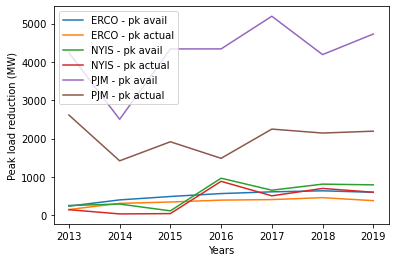

In [6]:
print(DR.head())
fig, ax = plt.subplots()
for ba in BAs:
    dr = DR.loc[ DR['BA'] == ba]
    ax.plot(dr['year'], dr['Peak Available (MW)'], label=f"{ba} - pk avail")
    ax.plot(dr['year'], dr['Peak Actual (MW)'], label=f"{ba} - pk actual")
plt.legend()
ax.set_xlabel('Years')
ax.set_ylabel('Peak load reduction (MW)')
plt.show()